In [74]:
import pandas as pd
import quandl
import math
import datetime
import numpy as np
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import pickle

style.use('ggplot')

In [63]:
df = quandl.get('WIKI/GOOGL')
df.head()

LimitExceededError: (Status 429) (Quandl Error QELx01) You have exceeded the anonymous user limit of 50 calls per day. To make more calls today, please register for a free Quandl account and then include your API key with your requests.

In [64]:
df = df[['Adj. Open','Adj. High','Adj. Low','Adj. Close','Adj. Volume']]
df.head()

KeyError: "['Adj. Open' 'Adj. High' 'Adj. Low'] not in index"

In [65]:
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

df=df[['Adj. Close','HL_PCT','PCT_change','Adj. Volume']]
df.head()

KeyError: 'Adj. High'

In [66]:
# Adj. Close is the "Label", the value being predicted
forecast_col = 'Adj. Close'
# Filling NAN values in the dataset
df.fillna(-99999, inplace=True)

# How far in the future we are predicting... forecasting 1 day
forecast_out = int(math.ceil(0.01*len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)

df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
Date,,,,,
2004-08-19,50.322842,3.712563,0.324968,44659000.0,69.639972
2004-08-20,54.322689,0.710922,7.227007,22834300.0,69.078238
2004-08-23,54.869377,3.729433,-1.227880,18256100.0,67.839414
2004-08-24,52.597363,6.417469,-5.726357,15247300.0,68.912727
2004-08-25,53.164113,1.886792,1.183658,9188600.0,70.668146


In [67]:
X = np.array(df.drop(['label'],1))
X = preprocessing.scale(X)
X = X[:-forecast_out]
# 30 days of values
X_lately = X[-forecast_out:]

df.dropna(inplace=True)
y = np.array(df['label'])

print(len(X),len(y))

3355 3355


In [76]:
X_train, X_test, y_train, y_test=cross_validation.train_test_split(X, y, test_size=0.2)
# Algorithm used is LinearRegression
##clf = LinearRegression(n_jobs=-1)
##clf.fit(X_train, y_train)
##with open('linearregression.pickle','wb') as f:
##    pickle.dump(clf, f)
    
pickle_in = open('linearregression.pickle','rb')
clf = pickle.load(pickle_in)

accuracy = clf.score(X_test, y_test)
# Another Algorithm is Support Vector Regression
clf_test = svm.SVR()
clf_test.fit(X_train, y_train)
accuracy_test = clf_test.score(X_test, y_test)

print('LinearRegression: '+str(accuracy))
print('SupportVectorRegression: '+str(accuracy_test))

LinearRegression: 0.9764184553354757
SupportVectorRegression: 0.8107250879892034


In [70]:
forecast_set = clf.predict(X_lately)

print(forecast_set)
print(accuracy)
print(forecast_out)

[1012.58627306 1053.21212095 1055.37147817 1055.4609176  1065.10459465
 1066.01515685 1073.17293847 1065.40408972 1075.72029277 1070.7300513
 1067.35666317 1063.93449206 1064.86591506 1059.41254229 1071.40934604
 1058.1302684  1057.64228389 1073.54024266 1075.21680923 1079.83068504
 1095.29308852 1085.68971375 1058.84923542 1058.55430367 1047.02881125
 1033.20503995 1040.67613519 1054.86559612 1067.30334774 1072.2167868
 1075.12483547 1070.9495142  1074.49670299 1080.11003982]
0.9786722524473755
34


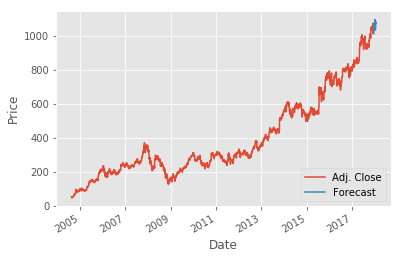

In [72]:
df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]
    
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()